# Machine Problem 3: NumPy CNN (cskang2)

### Import Libraries

In [1]:
import numpy as np
import os
import time
from scipy import signal
from imageio import imread
from random import shuffle
from matplotlib import pyplot as plt

%matplotlib inline

### Preprocessing Functions

In [2]:
# load_images
    # Read in images and makes a list for each set in the form: [images, labels]
    # images: np array with dims [N x img_height x img width x num_channels]
    # labels: np array with dims [N x 1]. elephant = 0, lionfish = 1
    #
    # Returns:  train_set: The list [train_images, train_labels]
    #           val_set: The list [val_images, val_labels] 

def load_images():
    
    sets = ['train', 'val']
    
    data_sets = []
    for dset in sets:
        img_path = './bin_dataset/' + dset + '/ele'
        ele_list = [imread(os.path.join(img_path, img)) for img in os.listdir(img_path)]

        img_path = './bin_dataset/' + dset + '/lio'
        lio_list = [imread(os.path.join(img_path, img)) for img in os.listdir(img_path)]

        set_images = np.stack(ele_list + lio_list)
        N = set_images.shape[0]
        labels = np.ones((N,1))
        labels[0:int(N/2)] = 0
        data_sets.append([set_images, labels])

    train_set, val_set = data_sets

    print("Loaded", len(train_set[0]), "training images")
    print("Loaded", len(val_set[0]), "validation images")
    
    return train_set, val_set


# batchify
    # Inputs:    train_set: List containing images and labels
    #            batch size: The desired size of each batch
    #
    # Returns:   image_batches: A list of shuffled training image batches, each with size batch_size
    #            label_batches: A list of shuffled training label batches, each with size batch_size 

def batchify(train_set, batch_size):
    
    # YOUR CODE HERE
    
    # Procedures: 
    # 1. Generate a list of all indices and shuffle them. 
    # 2. Create Batches of Dim (num_batch, batch_size, rows, cols, channels )
    
    # Basic Param
    num_image = train_set[0].shape[0] 
    num_batch = num_image / batch_size 
    image_batches = []
    label_batches = []

    
    # Shuffle Indices 
    image_indice = np.arange( num_image )
    shuffle(image_indice)
    
    # Assign Batch 
    for i in range( int(num_batch) ) :
        temp_image_batch = []
        temp_label_batch = [] 
        
        for j in range(batch_size) : 
            temp_image_batch.append( train_set[0][image_indice[i * batch_size + j] ])
            temp_label_batch.append( train_set[1][image_indice[i * batch_size + j] ])
        
        image_batches.append( temp_image_batch )
        label_batches.append( temp_label_batch )
        
    return image_batches, label_batches


### Network Functions

#### Activation Functions

In [3]:
# relu
    # Inputs:   x: Multi-dimensional array with size N along the first axis
    # 
    # Returns:  out: Multi-dimensional array with same size of x 

def relu(x):

    return np.maximum( np.zeros(x.shape), x )


# sigmoid
    # Inputs:    x: Multi-dimensional array with size N along the first axis
    # 
    # Returns:   out: Multi-dimensional array with same size of x 

def sigmoid(x):
    
    return 1/(1 + np.exp(-x) )


# unit_step
    # Inputs:    x: Multi-dimensional array with size N along the first axis 
    # 
    # Returns:   out: Multi-dimensional array with same size of x 

def unit_step(x):
    
    u_n = np.zeros( x.shape )
    u_n = 1 * ( x > 0 ) 
    
    return u_n 

#### Layer Functions

In [4]:
# convolve2D
    # Inputs:    X: [N x height x width x num_channels]
    #            filters: [num_filters x filter_height x filter_width x num_input_channels]
    # 
    # Returns:   Xc: output array by convoling X and filters. [N x output_height x output_width x num_filters]

def convolve2D(X0, filters):
   
    N, X0_len, _, num_ch = X0.shape
    num_out_ch, filter_len, _, _ = filters.shape
    F0_side = X0_len - filter_len + 1
    
    F0 = np.zeros((N, F0_side, F0_side, num_out_ch))
    
    for n in range(N):
        for o_ch in range(num_out_ch):
            for ch in range(num_ch):
                F0[n, :, :, o_ch ] += signal.convolve2d(filters[o_ch, :, :, ch], X0[n, :, :, ch], mode = "valid")
                
    return F0


# maxPool
    # Inputs:    R0: [N x height x width x num_channels]
    #            mp_len: size of max pool window, also the stride for this MP
    # 
    # Returns:   p_out: output of pooling R0. [N x output_height x output_width x num_channels]
    #            R0_mask: A binary mask with the same size as R0. Indicates which index was chosen to be the max
    #            for each max pool window. This will be used for backpropagation.

def maxPool(R0, mp_len):

    N, R0_len, _, num_ch = R0.shape
    p_out_len = int((R0_len-mp_len)/mp_len + 1)

    R0_mask = np.zeros(R0.shape)
    p_out = np.zeros((N, p_out_len, p_out_len, num_ch))
    
    for n in range(N):
        for ch in range(num_ch):
            for row in range(p_out_len): 
                for col in range(p_out_len):
                    
                    col_start = col * mp_len 
                    col_end = (col+1) * mp_len
                    row_start = row * mp_len 
                    row_end = (row+1) * mp_len
                    
                    sliced_pool = R0[n, row_start:row_end, col_start:col_end, ch ] 
                    
                    p_out[n, row, col, ch] = np.amax(sliced_pool) 
                    
                    max_loc = np.unravel_index( sliced_pool.argmax() , sliced_pool.shape ) 
                    R0_mask[n,row_start + max_loc[0], col_start + max_loc[1] , ch] = 1 
                    

    return p_out, R0_mask


# fc
    # Inputs:    X: [N x num_input_features]
    #            W: [num_input_features x num_fc_nodes]
    # 
    # Returns:   out: Linear combination of X and W. [N x num_fc_nodes]

def fc(X, W):
    
    return np.dot(X,W) 

#### CNN Functions

In [5]:
# cnn_fwd
    # Inputs:    X0: batch of images. [N x img_height x img_width x num_channels]
    #            W0, W1, W2: Parameters of the CNN
    #            mp_len: the length of one side of the max pool window
    # 
    # Returns:   sig: vector containing the output for each sample. [N x 1]
    #            cache: a dict containing the relevant output layer calculations that will be
    #            used in backpropagation
    
def cnn_fwd(X0, W0, W1, W2, mp_len):
    
    # F0 
    F0 = convolve2D(X0, W0)
    R0 = relu(F0) 
    
    # X1p 
    X1p, R0_mask = maxPool(R0, mp_len)
    
    # X1 (flatten)
    X1 = np.reshape(X1p, (X1p.shape[0], X1p.shape[1]*X1p.shape[2]*X1p.shape[3]) )
    
    # FC Layers
    F1 = fc(X1, W1)
    X2 = relu(F1)
    F2 = fc(X2, W2)
    
    # Output
    sig = sigmoid(F2)
    
    # Save outputs of functions for backward pass
    cache = {
        "F0":F0,
        "R0":R0,
        "X1p":X1p,
        "R0m":R0_mask,
        "X1":X1,
        "F1":F1,
        "X2":X2,
        "F2":F2      
    }
    
    return sig, cache


# loss
    # Inputs:    sig: vector containing the CNN output for each sample. [N x 1]
    #            Y: vector containing the ground truth label for each sample. [N x 1]
    # 
    # Returns:   L: Loss/error criterion for the model. 

def loss(sig, Y):
    
    L = (1/sig.shape[0]) * np.sum( -Y * np.log( sig )  - (1-Y) * np.log( 1 - sig )  )
    
    # L2 Regularization Term 
    # L += ( lamb / ( 2 * sig.shape[0] ) ) * ( np.sum( W0**2 ) + np.sum(W1**2) + np.sum(W2**2) )
        
    return L


### Backprop Functions

In [6]:
# convolve2DBwd
    # Inputs:    X0: batch of images. [N x height x width x num_channels]
    #            dL_dF0: Gradient at the output of the conv layer. 
    # 
    # Returns:   dL_dW0. gradient of loss L wrt W0. Same size as W0

def convolve2DBwd(X0, dL_dF0):
    
    N, X0_len, _, num_ch = X0.shape
    _, dL_dF0_len, _, num_out_ch  = dL_dF0.shape
    filter_len = X0_len - dL_dF0_len + 1
    
    dL_dW0 = np.zeros((num_out_ch, filter_len, filter_len, num_ch))
    
    for n in range(N):
        for o_ch in range(num_out_ch):
            for ch in range(num_ch):
                dL_dW0[o_ch, :, :, ch ] += signal.convolve2d( dL_dF0[n, :, :, o_ch ], np.rot90(X0[n, :, :, ch ], 2), mode = "valid" )         
    
    return dL_dW0


# maxPoolBwd
    # Inputs:    dL_dX1p: Gradient at the output of the MaxPool layer
    #            R0_mask: A binary mask with the same size as R0. Defined in maxPool
    #            mp_len: the length of one side of the max pool window
    # 
    # Returns:   dL_dR0: Gradient at the output of ReLu
    
def maxPoolBwd(dL_dX1p, R0_mask,  mp_len):
    
    N, H, W, C = R0_mask.shape
    N, dH, dW, C = dL_dX1p.shape
    
    dL_dR0 = np.zeros(R0_mask.shape)
    
    for n in range(N):
        for ch in range(C):
            for row in range(dH):
                for col in range(dW):
                    
                    col_start = col * mp_len 
                    col_end = (col+1) * mp_len
                    row_start = row * mp_len 
                    row_end = (row+1) * mp_len
                    
                    sliced_pool = R0_mask[n, row_start:row_end, col_start:col_end, ch ] 
                    dL_dR0[n, row_start:row_end, col_start:col_end, ch] = dL_dX1p[n, row, col, ch] * sliced_pool          
                    
    return dL_dR0


# dL_dW2
    # Inputs:    Y: vector containing the ground truth label for each sample. [N x 1]
    #            cache: a dict containing the relevant output layer calculations 
    # 
    # Returns:   dL_dW2: Gradient of the Loss wrt W2
    
def dL_dW2(Y, cache):
   
    X2 = cache["X2"] 
    F2 = cache["F2"]
    
    num = - ( (Y-1)  + Y * np.exp(-F2) )  
    dL_F2 = (1/F2.shape[0]) * num / ( 1 + np.exp(-F2)  )
                                                    
    return np.dot(X2.T, dL_F2)  


# dL_dW1
    # Inputs:    Y: vector containing the ground truth label for each sample. [N x 1]
    #            W2: Weight matrix for the second FC layer
    #            cache: a dict containing the relevant output layer calculations 
    # 
    # Returns:   dL_dW1: Gradient of the Loss wrt W1
    
def dL_dW1(Y, W2, cache):
    
    X2 = cache["X2"] 
    F2 = cache["F2"]
    F1 = cache["F1"]
    X1 = cache["X1"]
    
    num = - ( (Y-1)  + Y * np.exp(-F2) )  
    dL_F2 = (1/F2.shape[0]) * num / ( 1 + np.exp(-F2)  )
    
    dL_X2 = W2   
    dL_F1 = unit_step(F1) 
    
    dL_dX2 = np.dot(dL_F2, dL_X2.T)  
    dL_dF1 = dL_dX2 * dL_F1 

    return  np.dot(X1.T, dL_dF1) 


# dL_dW0
    # Inputs:    X0: batch of images. [N x height x width x num_channels]
    #            Y: vector containing the ground truth label for each sample. [N x 1]
    #            W1: Weight matrix for the first FC layer
    #            W2: Weight matrix for the second FC layer
    #            mp_len: the length of one side of the max pool window
    #            cache: a dict containing the relevant output layer calculations 
    # 
    # Returns:   dL_dW0: Gradient of the Loss wrt W0

def dL_dW0(X0, Y, W1, W2, mp_len, cache):
    
    N, X1p_len, _, no_out_ch  = cache['X1p'].shape
    F2 = cache['F2']
    F1 = cache['F1']
    X2 = cache['X2']
    X1 = cache['X1'] 
    
    R0m = cache['R0m']
    F0 = cache['F0']
    
    #dL_dF2
    num = - ( (Y-1)  + Y * np.exp(-F2) )  
    dL_F2 = (1/F2.shape[0]) * num / ( 1 + np.exp(-F2)  )
    
    #dL_dF1
    dL_X2 = W2   
    dL_F1 = unit_step(F1) 
    
    #dL_dX1
    dL_X1 = W1  
    
    dL_dX2 = np.dot(dL_F2, dL_X2.T)  
    dL_dF1 = dL_dX2 * dL_F1 
    dL_dX1 = np.dot(dL_dF1, dL_X1.T ) 
    
    # dL_dX1p (unflatten)
    dL_X1p = np.reshape( dL_dX1, (N, X1p_len, X1p_len, no_out_ch) )
    
    # dL_dR0 (unpool)
    dL_R0 = maxPoolBwd(dL_X1p, R0m,  mp_len)
    
    # dL_dF0 (relu_bwd)
    dL_F0 = unit_step(F0)
    dL_dF0 = dL_R0 * dL_F0 
    
    # dL_dW0
    dL_dW0 = convolve2DBwd(X0, dL_dF0)
    
    return dL_dW0
    
        

### Training

#### Load Images

In [17]:
# Load images and scale them

train_set, val_set = load_images() 

train_set[0] = train_set[0] / 255 
val_set[0] = val_set[0] / 255 


Loaded 2000 training images
Loaded 800 validation images


#### Config

In [18]:
# Hyperparameters
epochs = 20
lr = 0.1
batch_size = 16
filter_len = 5
num_out_ch = 3
mp_len = 12
fc_nodes = 2

# Declare weights
W0 = 0.05 * np.random.randn( 3,5,5,3 )
W1 = 0.05 * np.random.randn( 192,2 )
W2 = 0.05 * np.random.randn( 2,1 )

# Other Param: Accuracy per Epoch, L2 Regularization Lamb 
all_acc = []
lamb = 0.8 


In [19]:
for i in range(epochs):
    
    img_batches, label_batches = batchify( train_set, batch_size )

    for b_idx in range( int(train_set[0].shape[0] / batch_size) ):
        X = img_batches[b_idx]
        Y = label_batches[b_idx]
        
        # Forward pass
        X = np.array(X)
        Y= np.array(Y)
        
        # Adding Exponential Decay to Learning Rate 
#         lr = 0.1 * np.exp(-0.2 * i)
        
        sig, cache = cnn_fwd(X, W0, W1, W2, mp_len)
        
        # Calculate gradients
        w2_grad = dL_dW2(Y, cache) 
        w1_grad = dL_dW1(Y, W2, cache)
        w0_grad = dL_dW0(X, Y, W1, W2, mp_len, cache)
        
        # Update gradients
        W2 = W2 - lr * w2_grad 
        W1 = W1 - lr * w1_grad 
        W0 = W0 - lr * w0_grad 
    
        # L2 Regularization 
#         W2 = W2 - lr * (w2_grad + (lamb / batch_size) * W2 ) 
#         W1 = W1 - lr * (w1_grad + (lamb / batch_size) * W1 ) 
#         W0 = W0 - lr * (w0_grad + (lamb / batch_size) * W0 ) 
        
    # Obtaining Test Accuracy 
    
    sig, _ = cnn_fwd(val_set[0], W0, W1, W2, mp_len)
    test_acc = len(np.where(np.round(sig) == val_set[1])[0])/len(val_set[1])
    all_acc.append (test_acc)
    
    print("epoch: %d " %(i) )
    print("test_loss:", loss(sig, val_set[1]), "test_acc:", test_acc) 

epoch: 0 
test_loss: 0.6926807983936476 test_acc: 0.61625
epoch: 1 
test_loss: 0.6053562425140839 test_acc: 0.8025
epoch: 2 
test_loss: 0.524201700407284 test_acc: 0.82625
epoch: 3 
test_loss: 0.5406748013471306 test_acc: 0.58625
epoch: 4 
test_loss: 0.5356439565267429 test_acc: 0.6975
epoch: 5 
test_loss: 0.3070888547599851 test_acc: 0.88625
epoch: 6 
test_loss: 0.3313817549526668 test_acc: 0.87125
epoch: 7 
test_loss: 0.2996315122849721 test_acc: 0.88625
epoch: 8 
test_loss: 0.502738135592424 test_acc: 0.69
epoch: 9 
test_loss: 0.3523449743842629 test_acc: 0.8675
epoch: 10 
test_loss: 0.28416031423857263 test_acc: 0.87875
epoch: 11 
test_loss: 0.27249236140940764 test_acc: 0.8875
epoch: 12 
test_loss: 0.280480458774656 test_acc: 0.885
epoch: 13 
test_loss: 0.3824999511567866 test_acc: 0.81875
epoch: 14 
test_loss: 0.41285222701421276 test_acc: 0.79625
epoch: 15 
test_loss: 0.26066032087417124 test_acc: 0.89375
epoch: 16 
test_loss: 0.2659832812845108 test_acc: 0.89
epoch: 17 
test_lo

Text(0,0.5,'Test Accuracy')

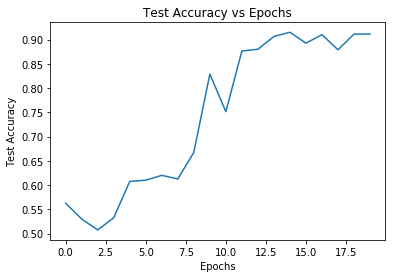

In [10]:
# Plotting Accuracy vs Epochs 

plt.plot( range(20), all_acc )
plt.title("Test Accuracy vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Test Accuracy")

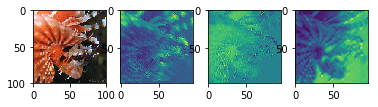

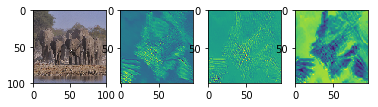

In [11]:
test_image = np.array(img_batches[0])
output_image = convolve2D(test_image, W0)

plt.figure()
plt.subplot(141) 
plt.imshow( test_image[3])  
plt.subplot(142)
plt.imshow( np.float64(output_image[3, :, :, 0] ) )
plt.subplot(143)
plt.imshow( np.float64(output_image[3, :, :, 1] ) )
plt.subplot(144)
plt.imshow( np.float64(output_image[3, :, :, 2] ) )

plt.figure()
plt.subplot(141) 
plt.imshow( test_image[10])  
plt.subplot(142)
plt.imshow( np.float64(output_image[12, :, :, 0])  )
plt.subplot(143)
plt.imshow( np.float64(output_image[12, :, :, 1])  )
plt.subplot(144)
plt.imshow( np.float64(output_image[12, :, :, 2])  )


In [21]:
# Confusion Matrix 0's are Elephants while 1's are Lionfish 
num_elph = len(np.where(np.round(sig[400:800]) == 0)[0])
num_fish = len(np.where(np.round(sig[400:800]) == 1)[0])

num_orig_elph = len(np.where(val_set[1] == 0)[0])
num_orig_fish = len(np.where(val_set[1] == 1)[0])

print(num_elph)
print(num_fish)
print(num_orig_elph)
print(num_orig_fish)
print(sig.shape)

62
338
400
400
(800, 1)


### Test Correctness of Forward and Backward Pass

#### Forward

In [13]:
weights = np.load('weights.npz')
W0 = weights['W0']
W1 = weights['W1']
W2 = weights['W2']

sig, cache = cnn_fwd(val_set[0], W0, W1, W2, mp_len)
train_acc = len(np.where(np.round(sig) == val_set[1])[0])/len(val_set[1])

print("train_loss:", loss(sig, val_set[1]), "train_acc:", train_acc)

train_loss: 0.23271396293817284 train_acc: 0.9175


#### Backward

In [14]:
# Make backprop testing batch
X_bp = np.vstack([train_set[0][0:8,:,:,:], train_set[0][-9:-1,:,:,:]])
Y_bp = np.vstack([train_set[1][0:8], train_set[1][-9:-1]])

# Initialize weights to all ones
W2 = np.ones( (2,1) )
W1 = np.ones( (192, 2) )
W0 = np.ones( (3,5,5,3) )

# Update weights once
# YOUR CODE HERE
sig, cache = cnn_fwd(X_bp, W0, W1, W2, mp_len)
w2_grad = dL_dW2(Y_bp, cache) 
w1_grad = dL_dW1(Y_bp, W2, cache)
w0_grad = dL_dW0(X_bp, Y_bp, W1, W2, mp_len, cache)

W2 = W2 - lr * w2_grad 
W1 = W1 - lr * w1_grad 
W0 = W0 - lr * w0_grad 

print("W2 value:", np.sum(W2))
print("W1 value:", np.sum(W1))
print("W0 value:", np.sum(W0))

W2 value: -834.631617647059
W1 value: -452.63161764705893
W0 value: -611.6316176470589
